# Assignment 1: Keeping Up With Social Information (Part 1)
## © Cristian Danescu-Niculescu-Mizil 2020
## CS/INFO 4300 Language and Information
## Due by midnight on Wednesday January 29th

This assignment is **individual**.

In this assignment we are practicing with post-processing on a conversational dataset taken from the reality TV show "Keeping Up With The Kardashians" and gathering some basic statistics about it. 

In the next assignment (Assignment 2) we will extend these tools to analyze conversational behavior.

**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* word tokenization
* histogram plotting using `matplotlib`
* character analysis via conversational language
* familiarize yourself with basic numpy usage

**Academic Integrity and Collaboration**

Note that these projects should be completed individually. As a result, all University-standard academic integrity guidelines must be followed.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.


You are unable to modify the read-only cells.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented within a given amount of time to ensure that your logic is correct.

Your solution to A1 should finish running in **less than 5 minutes**.
For your information, it takes less than 1 minute to run our solution for the entire A1.
Also make sure to remove any **redundant print statements** to speed things up and prevent generating unnecessary outputs.

For free-response questions you will be manually graded on the quality of your answer.

**Submission**

You are expected to submit this .ipynb as your submission for Assignment 1. 

In addition please submit an html copy of the notebook (You can create this by clicking File > Download as > HTML (.html)).

#### A0 Review

Recall the learning objectives of A0:

- The Jupyter Notebook environment
- Recap of Python syntax and basic data structures
- virtualenv environment for package dependencies

We used the BeautifulSoup library to extract episode titles, timestamps, and character speech from HTML files, then stored this data in Python Dictionaries. Finally, we conducted preliminary checks of our data to test its usability (i.e. checking for duplicate transcripts and converting nickname "Rob" to "Robert").

In [215]:
import re
import json
from glob import glob
import os
from io import StringIO
from itertools import groupby
import pickle

import numpy as np
import bs4
%matplotlib inline
import matplotlib.pyplot as plt

In [216]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

## Preliminary Data Cleansing
**Note: The following content is for you to review to understand how we cleaned and prepared the data for the analysis below.**

We will be continuing where we left off from Assignment 0. 

### Removing duplicates
If you are to examine the original transcripts you will see that many of them are near-duplicates, but most are not *perfect* duplicates. This is problematic, because we cannot simply remove identical transcripts.  Furthermore, we cannot just throw away documents that have large overlap, because we would be throwing away the valuable data that is *not* overlapping.

We therefore have to treat the transcripts as sequences, rather than as entire documents, and just remove subsequences that overlap.

We therefore used a standard python `difflib` package to write the `find_overlaps` function:

```python
import difflib
def find_overlaps(transcript_a, transcript_b, threshold=5):
    """Find and return the indices of overlapping subsequences between the two transcripts.
    Only return overlapping sequences that consist of at least `threshold` entries."""
    
    # We consider that two transcripts overlap when the messages
    # and the speakers are the same, but not the timestamp.
    
    # Massage the transcripts to disregard timestamp information.
    # note that a tuple is hashable, so is okay to use for difflib's SequenceMatcher class.
    msgs_a = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_a]
    msgs_b = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_b]
    matcher = difflib.SequenceMatcher(None, msgs_a, msgs_b)
    return list(filter(lambda tup: tup[2] >= threshold, matcher.get_matching_blocks()))
```

We now use the function above to remove duplicate subsequences. At each step, assume we have a list of "good" transcripts that have already been processed. When considering a new transcript, we first remove all subsequences that overlap with any of the already processed ones. Then, we split up the chunks that are not removed, and consider each of them a new transcript.

```python
deduped_transcripts = []
all_keys = sorted(transcripts.keys())

for key in all_keys:
    transcript = transcripts[key]
    for _, good_transcript in deduped_transcripts:
        overlaps = find_overlaps(transcript, good_transcript)
        for idx_a, _, size in overlaps:
            transcript[idx_a:idx_a + size] = [None] * size
    
    for is_not_none, group in groupby(transcript, lambda x: x is not None):
        if is_not_none:
            subtranscript = list(group)
            deduped_transcripts.append((key, subtranscript))
```

The `deduped_transcripts` are what you are now analyzing for the rest of the assignment. 

In [217]:
## We are loading the pickle file that contains all the deduped transcripts from Assignment 0
with open('deduped_transcripts.pickle','rb') as f:
    deduped_transcripts = pickle.load(f)
## We are also loading a pickle file of the titles file that we determined in the beginning of Assignment 0
with open('titles.pickle','rb') as f:
    titles = pickle.load(f)

In [218]:
deduped_transcripts.__class__

list

# Language analysis

## Identifying the words
It's time to get down to the bread-and-butter of language analysis: the words used.  For simplification, **we consider a word to be a sequence of alphabetical characters. Treat all other characters as delimiters and do not return them.**


## Question 1 (Code Completion): Tokenization 

In the cell below: *Write a function to 'tokenize' a string into the constituent words*. 

You **must** use regex to satisfy the function specification. We recommend you leverage `re.findall`. 

Hint: Check out this online regex calculator: [here](https://regex101.com/)

In [360]:
def tokenize(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    # YOUR CODE HERE
    T = text.lower()
    #r1 = re.findall(r"\b[^\d\W]+\b", T)
    r1 = re.split("\d+|\\s+|[!@#$%^&*\'\"]", T)
    #r1 = re.findall(r"\D+", T)
    return r1

In [368]:
def tokenize(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    # YOUR CODE HERE
    T = text.lower()
    r1 = re.findall(r"[a-zA-Z]+", T)
    return r1

In [369]:
mystring = "buy a 3m face's mask"
tokenize(mystring)

['buy', 'a', 'm', 'face', 's', 'mask']

In [370]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert tokenize("It's time 2 get down to the bread-and-butter") == \
    ['it', 's', 'time', 'get', 'down', 'to', 'the', 'bread', 'and', 'butter']
assert tokenize("Life, Liberty, & the Pursuit of Happiness") == \
    ['life', 'liberty', 'the', 'pursuit', 'of', 'happiness']

## Question 2 (Code Completion): Tokenization of Entire Transcript

In the cell below complete the function: *Leveraging the tokenize method to tokenize an entire transcript*. 

In [371]:
def tokenize_transcript(tokenize_method,input_transcript):
    """Returns a list of words contained in an entire transcript.
    Params: {tokenize_method: Function (a -> b),
             input_transcript: Tuple}
    Returns: List
    """
    # YOUR CODE HERE
    return sum([tokenize_method(text['text']) for text in input_transcript[1]], [])

In [372]:
len(deduped_transcripts)

1163

In [373]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert len(tokenize_transcript(tokenize,deduped_transcripts[0])) > 6000 and \
    len(tokenize_transcript(tokenize,deduped_transcripts[0])) < 7000

## Question 3 (Code Completion) Number of Tokens
In the cell below write a function to *count how many tokens are used in the deduplicated transcripts in total*

In [374]:
def num_dedup_tokens(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             // Note: Below type means a function that takes two arguments, the first of which is a function.
             tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    # YOUR CODE HERE
    tran_toke = []
    for epo in input_transcripts:
        toke = tokenize_transcript_method(tokenize_method,epo)
        tran_toke = tran_toke + toke
    return len(tran_toke)

In [375]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) > 200000 and \
    num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) < 300000

## Question 4 (Code Completion) Number of Distinct Words

In the cell below write a function to *count how many distinct words are in the deduplicated transcripts in total*. 

Hint: Use a *set*

In [376]:
def num_distinct_words(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of distinct tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             // Note: Below type means a function that takes two arguments, the first of which is a function.
             tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    # YOUR CODE HERE
    tran_toke = []
    for epo in input_transcripts:
        toke = tokenize_transcript_method(tokenize_method,epo)
        tran_toke = tran_toke + toke
    tran_toke = set(tran_toke)
    return len(tran_toke)


In [377]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) > 8000 and \
    num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) < 9000

# Question 5 (Code Completion) Word Episode Counts

This question is asking you to build a dictionary `word_episode_count[word]` = *number of episodes in which the word appears in*. 

*Note: Keep in mind that the de-duplicated transcripts don't have unique titles!
Recall from A0 that **one episode corresponds to exactly one title** (but not necessarily to only one transcript).*

**Your code should ideally take less than 1 second (or a few seconds) to run. If it does not, then you should be able to find a better answer.**

In the cell below write a function that: *for each distinct (unique) word, in how many different episodes does it appear?* 

In [378]:
from collections import defaultdict

def build_word_episode_count(tokenize_method,tokenize_transcript_method,input_transcripts,input_titles):
    """Returns a dictionary with the number of episodes each distinct word appears
        Params: {tokenize_method: Function (a -> b),
                 // Note: Below type means a function that takes two arguments, the first of which is a function.
                 tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
                 input_transcripts: Tuple List,
                 input_titles: Dictionary}
        Returns: Dict
    """
    # YOUR CODE HERE
    title_to_token = defaultdict(list)
    
    # Merge token by title
    for transcript in input_transcripts:
        title_to_token[input_titles[transcript[0]]] +=  tokenize_transcript_method(tokenize_method, transcript)
    all_words = []
    for key, value in title_to_token.items():
        title_to_token[key] = set(value)
        all_words = all_words + list(title_to_token[key])
    
    return Counter(all_words)

In [379]:
word_episode_count = build_word_episode_count(tokenize,tokenize_transcript,deduped_transcripts,titles)   

In [380]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_word_episode_count returns the correct output"""
assert word_episode_count['quarter'] == 2
assert word_episode_count['made'] == 40
assert word_episode_count['never'] == 49

## Question 6 (Free Response): Distribution Analysis

For this question you will be plotting a histogram of the distribution of the number of episodes in which words appear. 

The *x axis* should correspond to the *number of episodes* in which a word is mentioned, and the *y axis* should show *how many words* are in each bin. 

Note: Use the default matplotlib settings. You may find this tutorial helpful: https://matplotlib.org/3.0.2/tutorials/introductory/pyplot.html

Create a new cell with the histogram below. And give an analysis of the histogram: What do you observe?

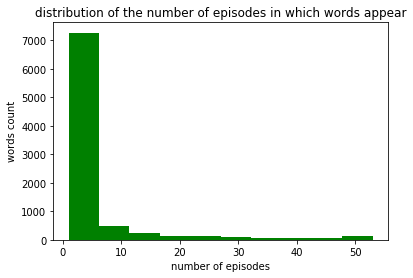

In [381]:
# YOUR CODE HERE

word_episode_count.keys()
plt.hist(word_episode_count.values(), color='g')
plt.ylabel('words count')
plt.xlabel('number of episodes')
plt.title('distribution of the number of episodes in which words appear')
plt.show()

## Question 7 (Code Completition): Good Types

For the following question you will build an alphabetically sorted list of all words that appear in **more than one episode.** We shall refer to these words as *good types*. The strategy here is to eliminate very specific words that occur too rarely. The word *type* here refers to word types. Word types are unique words, i.e. *hello* and *goodbye* are two distinct word types. ["You say goodbye, and I say hello, hello, hello"](https://www.youtube.com/watch?v=rblYSKz_VnI&feature=youtu.be&t=16s) (warning -- link will play sound) is a sequence of 9 tokens (ignoring punctuation) and contains one *goodbye* type token, and three *hello* type tokens.

In the cell below fulfill the specifications above and have the function: *produce an alphabetically sorted list of good types*. 

In [382]:
def output_good_types(input_word_counts):
    """Returns a list of good types in alphabetically sorted order
        Params: {input_word_counts: Dict}
        Returns: List
    """
    # YOUR CODE HERE
    good_words = []
    for key, value in input_word_counts.items():
        if value >1:
            good_words.append(key)
    good_words.sort() 
    return good_words
    

In [383]:
good_types = output_good_types(word_episode_count)
n_good_types = len(good_types)

In [384]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that output_good_types returns the correct output"""
assert n_good_types > 4500 and n_good_types < 5000
assert good_types[0:5] == ['a','aah','ability','able','about']

## Question 7b (Free Response): Good Types

In the cell below answer the following: *How many good_types there are? What are the first 10 in alphabetical order?*

Please write your answer in code and use Python's `print()` function, **NOT** markdown.

In [385]:
# YOUR CODE HERE
print(len(good_types))
print(good_types[0:10])

4517
['a', 'aah', 'ability', 'able', 'about', 'absolute', 'absolutely', 'absurd', 'accent', 'accept']


From now on, the use of array data structures from `numpy` is required in some places. If you've never used numpy before, it will take some time to get used to. In general, numpy is a library that you can use to handle vector/matrix/tensor operations, including creation, modification, and compositions (add, sub, mul, etc.). For example, try running the following code:

In [386]:
A = np.array([[1,2,3], [4,6,2]]) 
B = np.array([[1,2],[5,3],[1,1]])
print(A) #A is a 2x3 matrix
print(B) #B is a 3x2 matrix
print(A.dot(B)) #A.dot(B) is a 2 by 2 matrix
print(np.sum(A, axis=0)) #np.sum(A, axis=0) sums along columns
print(np.sum(B, axis=1)) #np.sum(B, axis=1) sums along rows

[[1 2 3]
 [4 6 2]]
[[1 2]
 [5 3]
 [1 1]]
[[14 11]
 [36 28]]
[5 8 5]
[3 8 2]


You're welcome to find your own resources to learn more about numpy (there are lots of them) but one good introduction is [Justin Johnson's writeup](http://cs231n.github.io/python-numpy-tutorial/#numpy).

We will be using vectors and arrays with *n_good_types* columns, such that each good type corresponds to a column, in alphabetical order.

## Question 8 (Code Completion): Word Frequencies

What can we say about the most frequently used words? Briefly consider, would you expect to find the same ordering of frequent words in, say, the NY Times?

Note that we are talking about the frequency a word appears across the entire corpus, rather than how many episodes a word appears in.

In the cell below, complete the function to *find the word frequency of all "good types"* in descending order.

Notes: corpus is a collection of written texts, in this case the transcripts of a reality TV show. Frequency is the rate at which something occurs.

For this question only, **round your solution to 5 decimals**.

In [387]:
from collections import OrderedDict

def create_ranked_good_types(tokenize_method,tokenize_transcript_method,input_transcripts,input_good_types):
    """Returns a list of good types in reverse sorted order in the form:
        [(word_1,word_frequency_1),
        ...
        (word_10,word_frequency_10)]
        Params: {tokenize_method: Function (a -> b),
                 // Note: Below type means a function that takes two arguments, the first of which is a function.
                 tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
                 input_transcripts: Tuple List,
                 input_good_types: List}
        Returns: List
    """
    # YOUR CODE HERE
    all_words=[]
    for i in range(len(input_transcripts)):
        all_words =  all_words + tokenize_transcript_method(tokenize_method,input_transcripts[i])
    all_dict = Counter(all_words)
    length = len(all_words)
    
    good_words_dict = {}
    for word in input_good_types:
        good_words_dict[word] = round(all_dict[word]/length,5)
           
    listofTuples = sorted(good_words_dict.items() ,  key=lambda x: x[1] , reverse = True)

    return listofTuples

In [389]:
ranked_frequencies = create_ranked_good_types(tokenize,tokenize_transcript,deduped_transcripts,good_types)

Suggestion: Sum the word frequencies found for all good types. Consider why they do not add to one.

In [390]:
total = 0
for (a, b) in ranked_frequencies:
    total +=b
total


0.9798599999999208

In [391]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_ranked_good_types returns the correct output"""
assert ranked_frequencies[0:2] == [('i', 0.04858), ('you', 0.03797)]

In [392]:
ranked_frequencies[0:2]

[('i', 0.04858), ('you', 0.03797)]

## Characterizing characters' language

Moving on, we will only be considering a subset of characters, arguably the most important ones.

In [273]:
good_speakers = [u'BRUCE',
                 u'JONATHAN',
                 u'KHLOE',
                 u'KIM',
                 u'KOURTNEY',
                 u'KRIS',
                 u'ROBERT',
                 u'SCOTT']

n_speakers = len(good_speakers)

In [404]:
good_speakers[2]

'KHLOE'

## Question 9 (Code Completion): Character Word Occurrences

In the cell below you will be asked to determine the *occurrences words by each character*

This function **requires** you to return a numpy array of shape `n_speakers` by `n_good_types` such that the entry `(i,j)` indicates how many times speaker i says word j. 

Note: you will lose points if you do not use numpy.

In [551]:
def create_word_occurrence_matrix(
    tokenize_method,
    input_transcripts,
    input_speakers,
    input_good_types):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j.
    
    Params: {tokenize_method: Function (a -> b),
             input_transcripts: Tuple List,
             input_speakers: List,
             input_good_types: List}
    Returns: Numpy Array
    """
   
    """
    A = np.zeros((len(input_speakers), len(input_good_types)))
    
    speaker_word = defaultdict(list)
    for transcript in input_transcripts:
        for dic in transcript[1]:
            speaker_word[dic['speaker']] += tokenize_method(dic['text'])
    
    
    for i in range(len(input_speakers)):
        for j in range(len(input_good_types)):
            A[i,j] = speaker_word[input_speakers[i]].count(input_good_types[j])
            
    return A
    """
    # YOUR CODE HERE
    A = np.zeros((len(input_speakers), len(input_good_types)))
    
    
    
    for i in range(len(input_speakers)):
        words = []
        for transcript in input_transcripts:
            for dic in transcript[1]:
                if dic['speaker'] == input_speakers[i]:
                    words = words + tokenize_method(dic['text'])
                    
        for j in range(len(input_good_types)):
            A[i,j] = words.count(input_good_types[j])
            
    return A

In [552]:
word_matrix = create_word_occurrence_matrix(tokenize,deduped_transcripts,good_speakers,good_types)

In [553]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(word_matrix[0]) > 26000.0
assert sum(word_matrix[:,3]) > 40 and sum(word_matrix[:,3]) < 50
assert type(word_matrix) == np.ndarray

## Question 9b (Free Response): Character Word Occurrences

In the cell below, output the *top 10 most occurring words used by each character* in the following format (if you encounter ties, then any ordering is acceptable):

**Answer format**:

```
CHARACTER_NAME_A
word_1
word_2
...
word_10

CHARACTER_NAME_B
word_1
word_2
...
word_10

...
```

In [554]:
# YOUR CODE HERE
word_matrix.shape
for i in range(word_matrix.shape[0]):
    word_sort_index = list(np.argsort(word_matrix[i]))
    print(good_speakers[i])
    find_index = word_sort_index[::-1][:10]
    for j in find_index:
        print(good_types[j])
    print()

BRUCE
i
you
the
s
to
it
a
and
that
this

JONATHAN
i
you
to
the
s
a
it
and
like
this

KHLOE
i
you
to
and
s
a
the
it
that
like

KIM
i
you
to
and
s
the
it
a
that
like

KOURTNEY
i
to
you
and
s
it
the
a
that
t

KRIS
i
you
to
s
the
a
and
it
that
t

ROBERT
i
to
you
s
and
a
the
just
it
that

SCOTT
i
you
to
s
the
a
it
that
and
t



## Question 9c (Code Completion): Character Word Occurrences

Using your `word_matrix`, identify the characters (in descending order of number of occurrences) who have said **all** of the following words: `["shopping", "sorry", "sister"]`. 

Please note: a character must have spoken each word at least once to be included in your answer (if you encounter ties, then any ordering is acceptable).

In the cell below, output your answer in the following format:

**Answer format**:

```
shopping
CHARACTER_NAME_A occurrences_shopping_A
CHARACTER_NAME_B occurrences_shopping_B
...

sorry
CHARACTER_NAME_A occurrences_sorry_A
CHARACTER_NAME_B occurrences_sorry_B
...

sister
CHARACTER_NAME_A occurrences_sister_A
CHARACTER_NAME_B occurrences_sister_B
...
```


In [555]:
interesting_words = ["shopping", "sorry", "sister"]

In [556]:
# YOUR CODE HERE
for word in interesting_words:
    index_interesting = good_types.index(word)
    
    word_matrix[:, index_interesting]
    frequency_sort_index = list(np.argsort(word_matrix[:, index_interesting]))
    frequency_sort_index
    frequency_sort_index_new = []
    for index in frequency_sort_index:
        if word_matrix[index, index_interesting] > 0:
            frequency_sort_index_new.append(index)
    frequency_sort_index_new
    frequency_sort_index_reverse = frequency_sort_index_new[::-1]
    print(word)
    for index in frequency_sort_index_reverse:
        print(good_speakers[index]+' ' + str(word_matrix[index, index_interesting]))
    print()

shopping
KIM 41.0
KOURTNEY 37.0
KRIS 6.0
KHLOE 6.0
BRUCE 2.0

sorry
KHLOE 38.0
KRIS 34.0
KIM 31.0
ROBERT 13.0
KOURTNEY 12.0
JONATHAN 9.0
SCOTT 7.0
BRUCE 4.0

sister
KOURTNEY 25.0
KHLOE 22.0
KRIS 13.0
KIM 9.0
SCOTT 6.0
ROBERT 6.0
BRUCE 2.0



## Question 10 (Code Completion): Word Character Counts

In the questions below you will now be asked to determine *how many characters have used a specific word*? For example, how many characters have ever said "botox" in the show?

The function below will require you to use the `word_matrix` from above to return a 1-D numpy array that reports the number of `good_speakers` that have uttered each word within `good_types`.
The i-th entry of your answer array `word_character_count_array[i]` should be the number of characters that have uttered the word `good_types[i]`.

Hint! Numpy is your friend :-)

In [557]:
def create_word_character_count_array(word_freq_matrix):
    """Returns a numpy array of shape (n_good_types,) such that the 
    entry i indicates how many good_speakers have uttered word i.
    
    Params: { word_freq_matrix: a numpy matrix of shape (n_speakers, n_good_types) }
    
    Hint: You may want to consult the numpy documentation to make this easy.
    """
    # YOUR CODE HERE
    count_list = []
    for i in range(len(good_types)):
        word_freq = list(word_freq_matrix[:, i])
        count = 0
        for i in word_freq:
            if i >0:
                count+=1
            
        count_list.append(count)
    return np.array(count_list)
        

In [558]:
word_character_count_array = create_word_character_count_array(word_matrix)

In [559]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_character_word_count_array returns the correct output"""
assert type(word_character_count_array) == np.ndarray
assert word_character_count_array[0] == 8
assert word_character_count_array[1] == 2

## Question 10b (Free Response): Word Character Counts

What are the first 10 words (sorted in alphabetical order) that are said by **at least 5** characters?

In the cell below, give your answer in the following format:

**Answer format**:

```
word_1
word_2
...
word_10
```


In [560]:
# YOUR CODE HERE
word_5_chara = []
for index in range(len(word_character_count_array)):
    if word_character_count_array[index]>=5:
        word_5_chara.append(good_types[index])
word_5_chara = sorted(word_5_chara, reverse = False)
word_5_chara[:5]

['a', 'able', 'about', 'absolutely', 'accept']

## Question 11 (Code Completion): Specific Word Usage by Character

The exercise in 9b didn't help much in understanding each character's diction, because common words are used too commonly anyway. We want to give more weight to less frequent words, as they carry more information on the particularities of the characters.

A simple way to do this is to score the words according to the ratio between how often a given character said the word and how often any of the *good speakers* said it.  

This can be accomplished by dividing each columns in the `word_array` matrix by its sum.

**Note: as some words might never be said by the key characters we are considering, add 1 to the sum of each column to avoid division by 0**

In the cell below, complete the function to return a weighted numpy array of *specific* words used by each character?

In [572]:
import copy

def create_weighted_word_freq_array(input_word_array):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j weighted by the above ratio.
    
    Note: You must add 1 to the sum of each column to avoid divison by 0 issues.
    
    Params: {input_word_array: Numpy Array}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    word_array = copy.deepcopy(word_matrix)
    column_sum = []
    for i in range(input_word_array.shape[1]):
        column_sum.append(np.sum(input_word_array[:, i]))
    for j in range(input_word_array.shape[1]):
        word_array[:, j] = input_word_array[:, j]/(column_sum[j]+1)
    return word_array

In [573]:
weighted_words = create_weighted_word_freq_array(word_matrix)

In [567]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(weighted_words[:,7]) > 0.7
assert type(weighted_words) == np.ndarray

## Question 11b (Free Response): Specific Word Usage by Character

Use the next cell to output the top 10 most *specific* words (in descending order) used by each character in the following format:

**Answer format**:

```
CHARACTER_NAME_A
score_1 word_1
score_2 word_2
...
score_10 word_10

CHARACTER_NAME_B
score_1 word_1
score_2 word_2
...
score_10 word_10

...
```

In [569]:
# YOUR CODE HERE
weighted_words.shape
for i in range(weighted_words.shape[0]):
    word_sort_index = list(np.argsort(weighted_words[i]))
    print(good_speakers[i])
    find_index = word_sort_index[::-1][:10]
    for j in find_index:
        print(good_types[j])
    print()

BRUCE
genetic
hobby
planners
brake
carpool
presentation
robbie
mcdonald
toughest
surgeries

JONATHAN
erika
pics
katie
awareness
simon
command
oats
beckham
carmen
homely

KHLOE
fur
basic
apparently
secure
campaign
furs
moral
begins
fulfilled
vandalizing

KIM
amusing
song
frizz
challenge
humiliating
punched
hotwire
airport
signs
advantage

KOURTNEY
ho
defensive
escalated
busted
version
theb
absurd
sober
driveway
cushion

KRIS
sweetie
cristal
cranky
shops
kenneth
los
angeles
chat
maker
department

ROBERT
email
anal
truly
adrian
scream
acceptable
overnight
spoken
erection
cheating

SCOTT
sitter
exclamation
gentlemen
hooker
fella
fabu
brucinator
custom
squat
thr



## Question 11c (Free Response): Specific Word Usage by Character

Now we can start to see interesting differences between the characters.

Create a new Markdown cell bellow and use it to write a paragraph discussing the differences you find most striking.

YOUR ANSWER HERE
Before i calculate weighted word frequency, the top 10 most specific words used by each character are mostly some stopwords or irrelevent words like this, that, the and so on.
the result is not useful to tell which word is important for a character.
however, after i divide each columns in the word_array matrix by its sum, then some words like this, the denominator is quite large, therefore 'this' is deluted by large denominator.
as i choose the top 10 most specific words, 'this' does not appear in the top list. instead, some words which are not frequent among all the speaker appear in the list

This is the end of Assignment 1